# Real-Time Bitcoin Sentiment Analysis Using txtai

This project uses real-time news headlines and Bitcoin pricing data to evaluate market sentiment and predict short-term price movements. Tools include:

- [txtai](https://github.com/neuml/txtai) for semantic search and sentiment analysis
- [NewsAPI](https://newsapi.org/) for real-time crypto-related news
- [CoinGecko API](https://www.coingecko.com/en/api) for Bitcoin price data
- Time-series models (ARIMA) for forecasting

## 1. Environment Setup

We begin by installing and importing the necessary Python packages. These include:

- `txtai` for semantic search and sentiment analysis
- `requests` for communicating with external APIs (NewsAPI and CoinGecko)
- `pandas` for working with tabular data
- `matplotlib` and `seaborn` for visualizing price and sentiment trends
- `datetime` for handling timestamps and date alignment

These tools provide the foundation for data ingestion, processing, and visualization in this notebook.

In [4]:
# import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Custom utility functions
from txtai_utils import (
    TxtaiSentimentSearch,
    fetch_bitcoin_headlines,
    analyze_sentiment,
    run_arima_forecast)

## 2. Fetch Real-Time News and Analyze Sentiment

We use NewsAPI to fetch live Bitcoin-related news headlines and analyze them using `txtai`'s sentiment pipeline.

In [5]:
# Set your NewsAPI key
API_KEY = "6e540235a1794f78a804270f2317adf3"  # Replace with your actual NewsAPI key
headlines = fetch_bitcoin_headlines(API_KEY)
today = datetime.utcnow().date()
sentiments = [analyze_sentiment(h) for h in headlines]

# Create sentiment DataFrame
df_sentiment = pd.DataFrame({
    "date": today,
    "headline": headlines,
    "sentiment": sentiments
})

INFO:txtai_utils:Fetching Bitcoin news headlines from NewsAPI...
INFO:txtai_utils:Fetched 100 headlines.
INFO:txtai_utils:Loading sentiment pipeline...
INFO:txtai_utils:Analyzed: '12 more charged in $263M crypto theft ring that blew it on booze and cars' → NEGATIVE (1.00)
INFO:txtai_utils:Loading sentiment pipeline...
INFO:txtai_utils:Analyzed: 'Bitcoin Rises While Ethereum, Dogecoin Slip — 'Market Isn't Going To Peak In The Next 6 Months,' Says Popular Analyst' → NEGATIVE (1.00)
INFO:txtai_utils:Loading sentiment pipeline...
INFO:txtai_utils:Analyzed: 'Coinbase drops 7% on customer breach, SEC probe into user numbers' → NEGATIVE (1.00)
INFO:txtai_utils:Loading sentiment pipeline...
INFO:txtai_utils:Analyzed: 'XRP Price Sinks Lower, But Chart Whisperers See a Trap for The Bears' → NEGATIVE (1.00)
INFO:txtai_utils:Loading sentiment pipeline...
INFO:txtai_utils:Analyzed: 'Bitcoin Treasury Fever Hits The Middle East' → NEGATIVE (0.76)
INFO:txtai_utils:Loading sentiment pipeline...
INFO:tx

## 3. Fetch Bitcoin Price from CoinGecko

We retrieve historical Bitcoin prices from the CoinGecko API to align with the news sentiment data.

In [6]:
def fetch_bitcoin_prices(days=7):
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {"vs_currency": "usd", "days": days}
    r = requests.get(url, params=params)
    data = r.json()
    prices = [(datetime.fromtimestamp(ts / 1000).date(), price) for ts, price in data["prices"]]
    return pd.DataFrame(prices, columns=["date", "price"])
# Load price data
df_prices = fetch_bitcoin_prices(days=7)

## 4. Merge Sentiment with Price Data

We align news sentiment and price data by merging on the date field.

In [7]:
df_merge = pd.merge(df_sentiment, df_prices, on="date", how="inner")

## 5. Visualize Price and Sentiment Trends

We create two visualizations: a line plot for price and a bar chart for sentiment distribution.

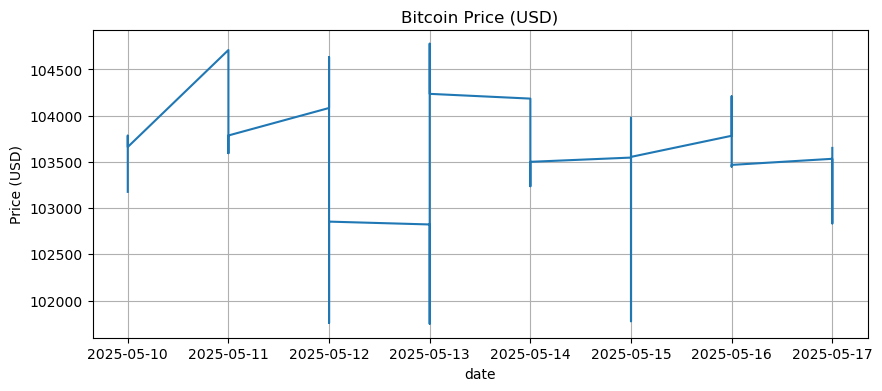

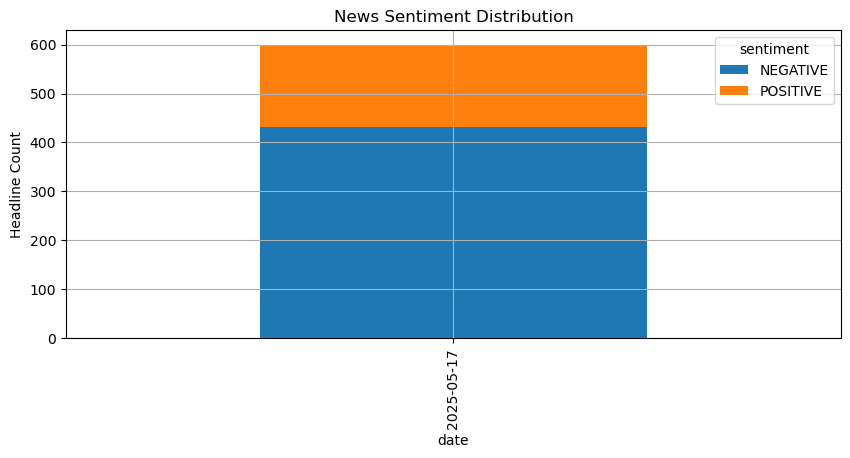

In [8]:
# Price Line Plot
df_prices.set_index("date")["price"].plot(title="Bitcoin Price (USD)", figsize=(10, 4))
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

# Sentiment Bar Plot
df_summary = df_merge.groupby(["date", "sentiment"]).size().unstack().fillna(0)
df_summary.plot(kind="bar", stacked=True, figsize=(10, 4), title="News Sentiment Distribution")
plt.ylabel("Headline Count")
plt.grid(True)
plt.show()

## 6. Forecasting Bitcoin Prices with ARIMA

In this section, we use ARIMA to model and forecast Bitcoin prices based on the past 30 days of data.
We first clean and validate the time series before fitting the model.

In [9]:
# Fetch 30 days of Bitcoin prices
df_prices = fetch_bitcoin_prices(days=30)

# Remove duplicate dates by grouping and averaging (or use .last() if you prefer)
df_prices = df_prices.groupby("date").mean().reset_index()

# Convert to daily frequency
df_prices = df_prices.set_index("date").asfreq("D")

# Fill missing values by forward filling
df_prices["price"] = df_prices["price"].fillna(method="ffill")

In [10]:
# print sanity check to make sure prices aren't all zeros or NaNs
print(df_prices.tail())
print("NaN count:", df_prices["price"].isna().sum())
print("Min/Max price:", df_prices["price"].min(), df_prices["price"].max())

                    price
date                     
2025-05-13  103314.403202
2025-05-14  103646.730487
2025-05-15  102829.450346
2025-05-16  103837.098217
2025-05-17  103347.388328
NaN count: 0
Min/Max price: 84633.45187606933 104180.8741726982


INFO:txtai_utils:Running ARIMA forecast on 'price' column...
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:txtai_utils:Forecasting complete for 7 steps ahead.


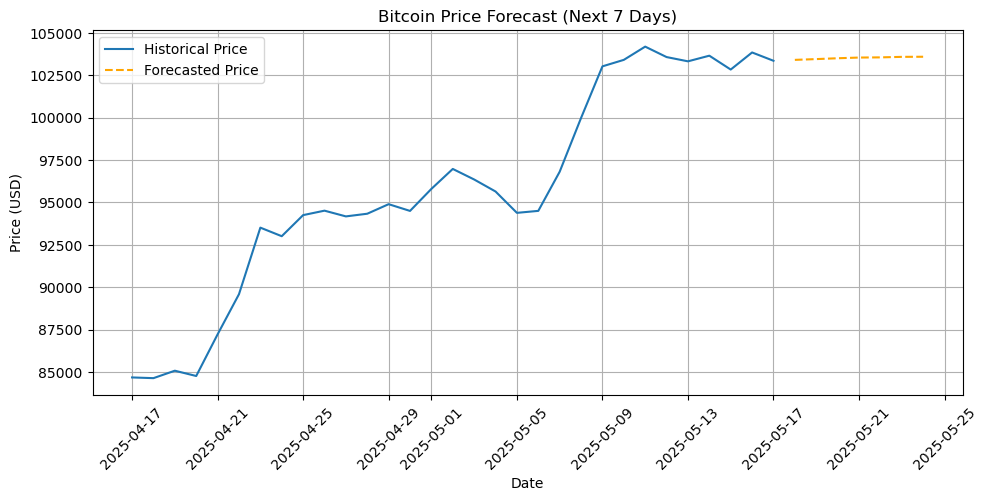

In [11]:
# Run ARIMA forecast using the modular function
forecast_df = run_arima_forecast(df_prices, order=(5, 1, 2), steps=7)

# Plot forecasted vs historical data
plt.figure(figsize=(10, 5))
plt.plot(df_prices.index, df_prices["price"], label="Historical Price")
plt.plot(forecast_df.index, forecast_df["forecast"],
         label="Forecasted Price", color="orange", linestyle="--")

plt.title("Bitcoin Price Forecast (Next 7 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

## Conclusion

In this notebook, we:

- Retrieved real-time Bitcoin news and price data
- Performed sentiment analysis
- Merged and visualized sentiment vs. market movement
- Forecasted future prices using an ARIMA model